# NLPCA vs Linear PCA Benchmark

This notebook implements a Non-Linear Principal Component Analysis (NLPCA) Autoencoder based on Kramer (1991) and benchmarks it against a standard Linear PCA Autoencoder.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Loading and Preprocessing

In [3]:
class NlpcaDataset(Dataset):
    def __init__(self, csv_file):

        self.raw_data = pd.read_csv(csv_file)
        
        # scales data to mean 0 and variance 1
        self.scaler = StandardScaler()
        self.data = self.scaler.fit_transform(self.raw_data.values)
        
        # convert to PyTorch tensors
        self.data = torch.FloatTensor(self.data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_input_dim(self):
        return self.data.shape[1]

# Load Datasets
dataset_example1 = NlpcaDataset('example1_synthetic_dataset.csv')
dataset_100dim = NlpcaDataset('100-dim-batch_dataset.csv')

dataloader_example1 = DataLoader(dataset_example1, batch_size=32, shuffle=True)
dataloader_100dim = DataLoader(dataset_100dim, batch_size=32, shuffle=True)

print(f"Example1 Dataset shape: {dataset_example1.data.shape}")
print(f"100-dim Dataset shape: {dataset_100dim.data.shape}")

Example1 Dataset shape: torch.Size([100, 2])
100-dim Dataset shape: torch.Size([25, 100])


## Model Definition

### NLPCA Autoencoder (Kramer 1991)
Structure: Input ($N$) -> Mapping ($M_1$, Sigmoid) -> Bottleneck ($J$, Linear) -> De-mapping ($M_2$, Sigmoid) -> Output ($N$, Linear)

### PCA Model
Structure is defined as a 3 layer (1 hidden layer) model as defined in the paper in page 4.


In [4]:
class NLPCAAutoencoder(nn.Module):
    def __init__(self, input_dim, mapping_dim, bottleneck_dim):
        super(NLPCAAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, mapping_dim),
            nn.Sigmoid(),
            nn.Linear(mapping_dim, bottleneck_dim) # Linear for bottleneck outputs
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, mapping_dim),
            nn.Sigmoid(),
            nn.Linear(mapping_dim, input_dim) # Linear output
        )
        
    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstruction = self.decoder(bottleneck)
        return reconstruction, bottleneck

class LinearPCAAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super(LinearPCAAutoencoder, self).__init__()
        
        self.encoder = nn.Linear(input_dim, bottleneck_dim)
        self.decoder = nn.Linear(bottleneck_dim, input_dim)
        
    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstruction = self.decoder(bottleneck)
        return reconstruction, bottleneck

## Training Loop

In [5]:
def train_model(model, dataloader, epochs=500, learning_rate=0.001, verbose_freq=100):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.to(device)
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in dataloader:
            batch = batch.to(device)
            
            # Forward pass
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * batch.size(0)
        
        epoch_loss /= len(dataloader.dataset)
        loss_history.append(epoch_loss)
        
        if (epoch + 1) % verbose_freq == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}')
            
    return loss_history

## Dataset 1: Synthetic Dataset for batch reaction (chemical kinetics formula ig) ($N=2, J=1$)

Training Models on 2D Dataset (Input Dim: 2, Bottleneck: 1)...
Linear PCA training...
Epoch [100/2000], Loss: 0.555046
Epoch [200/2000], Loss: 0.495856
Epoch [300/2000], Loss: 0.489272
Epoch [400/2000], Loss: 0.486627
Epoch [500/2000], Loss: 0.484609
Epoch [600/2000], Loss: 0.483053
Epoch [700/2000], Loss: 0.481281
Epoch [800/2000], Loss: 0.479602
Epoch [900/2000], Loss: 0.477483
Epoch [1000/2000], Loss: 0.475603
Epoch [1100/2000], Loss: 0.475437
Epoch [1200/2000], Loss: 0.474600
Epoch [1300/2000], Loss: 0.473828
Epoch [1400/2000], Loss: 0.473344
Epoch [1500/2000], Loss: 0.473381
Epoch [1600/2000], Loss: 0.473262
Epoch [1700/2000], Loss: 0.473168
Epoch [1800/2000], Loss: 0.473309
Epoch [1900/2000], Loss: 0.473226
Epoch [2000/2000], Loss: 0.473094
NLPCA training...
Epoch [100/2000], Loss: 0.805062
Epoch [200/2000], Loss: 0.532495
Epoch [300/2000], Loss: 0.530799
Epoch [400/2000], Loss: 0.529608
Epoch [500/2000], Loss: 0.528313
Epoch [600/2000], Loss: 0.527266
Epoch [700/2000], Loss: 0.5

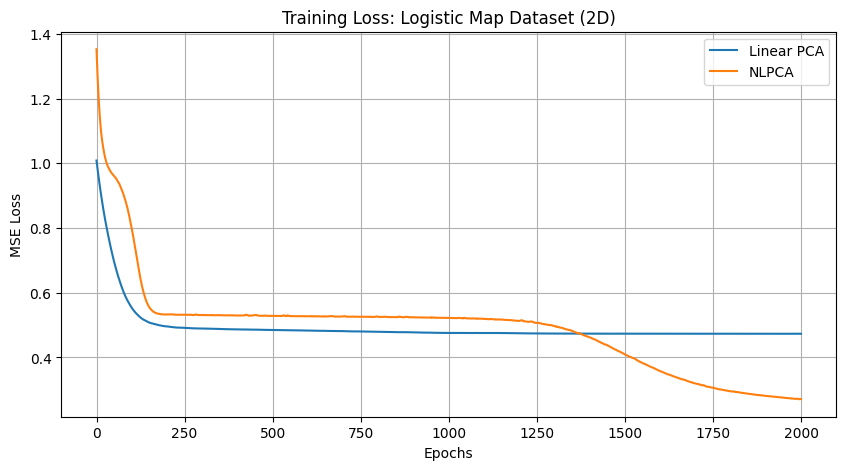

Final Linear PCA Loss: 0.473094
Final NLPCA Loss: 0.271289


In [6]:
# Parameters
input_dim = dataset_example1.get_input_dim()
bottleneck_dim = 1
mapping_dim = 10 # change for tests
epochs = 2000

print(f"Training Models on 2D Dataset (Input Dim: {input_dim}, Bottleneck: {bottleneck_dim})...")

print("Linear PCA training...")
linear_model_2d = LinearPCAAutoencoder(input_dim, bottleneck_dim)
loss_linear_2d = train_model(linear_model_2d, dataloader_example1, epochs=epochs)

print("NLPCA training...")
nlpca_model_2d = NLPCAAutoencoder(input_dim, mapping_dim, bottleneck_dim)
loss_nlpca_2d = train_model(nlpca_model_2d, dataloader_example1, epochs=epochs)

#loss plots

plt.figure(figsize=(10, 5))
plt.plot(loss_linear_2d, label='Linear PCA')
plt.plot(loss_nlpca_2d, label='NLPCA')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss: Logistic Map Dataset (2D)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Linear PCA Loss: {loss_linear_2d[-1]:.6f}")
print(f"Final NLPCA Loss: {loss_nlpca_2d[-1]:.6f}")

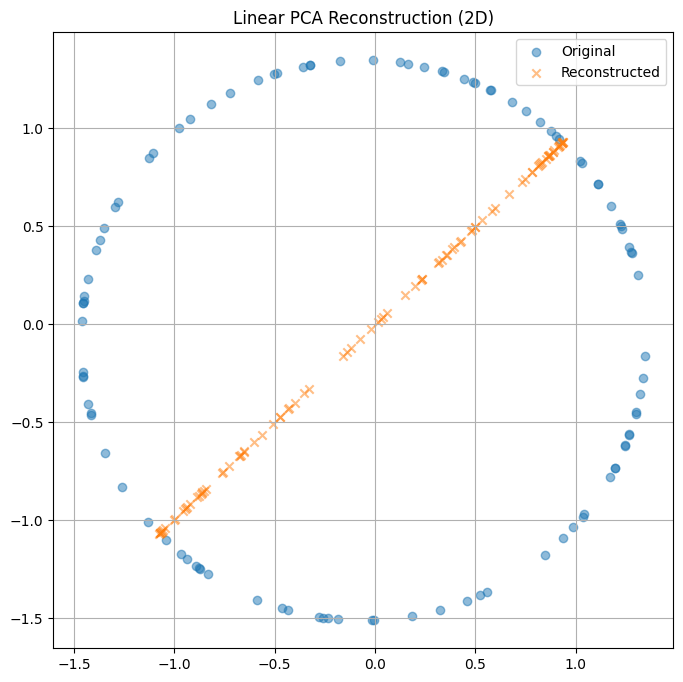

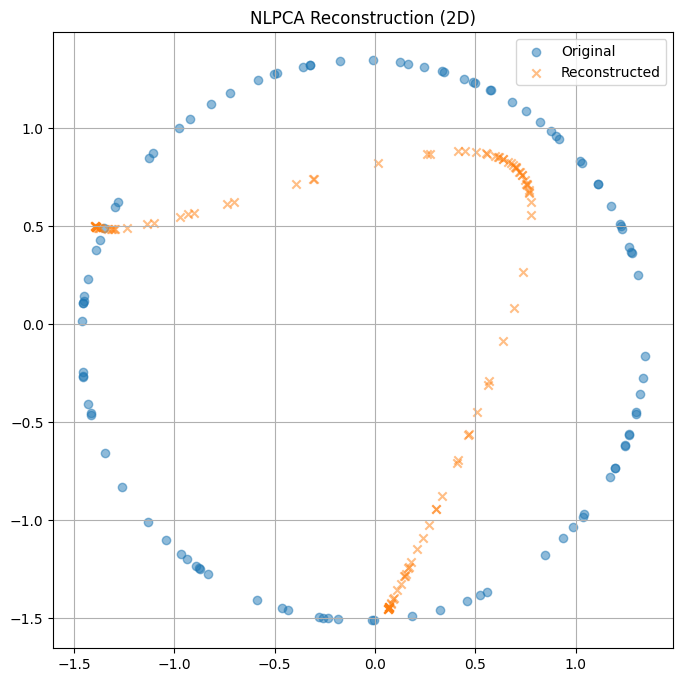

In [7]:
# asked llm for help but welp
def visualize_reconstruction_2d(model, dataset, title):
    model.eval()
    with torch.no_grad():
        data = dataset.data.to(device)
        reconstruction, _ = model(data)
        reconstruction = reconstruction.cpu().numpy()
        original = data.cpu().numpy()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(original[:, 0], original[:, 1], alpha=0.5, label='Original')
    plt.scatter(reconstruction[:, 0], reconstruction[:, 1], alpha=0.5, label='Reconstructed', marker='x')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_reconstruction_2d(linear_model_2d, dataset_example1, "Linear PCA Reconstruction (2D)")
visualize_reconstruction_2d(nlpca_model_2d, dataset_example1, "NLPCA Reconstruction (2D)")

## Dataset 2: 100 Dimension Dataset ($N=100, J=10$)

Training Models on 100D Dataset (Input Dim: 100, Bottleneck: 10)...
Linear PCA training...
Epoch [100/2000], Loss: 0.088768
Epoch [200/2000], Loss: 0.003277
Epoch [300/2000], Loss: 0.000736
Epoch [400/2000], Loss: 0.000167
Epoch [500/2000], Loss: 0.000048
Epoch [600/2000], Loss: 0.000027
Epoch [700/2000], Loss: 0.000024
Epoch [800/2000], Loss: 0.000023
Epoch [900/2000], Loss: 0.000023
Epoch [1000/2000], Loss: 0.000023
Epoch [1100/2000], Loss: 0.000023
Epoch [1200/2000], Loss: 0.000023
Epoch [1300/2000], Loss: 0.000023
Epoch [1400/2000], Loss: 0.000023
Epoch [1500/2000], Loss: 0.000023
Epoch [1600/2000], Loss: 0.000023
Epoch [1700/2000], Loss: 0.000022
Epoch [1800/2000], Loss: 0.000022
Epoch [1900/2000], Loss: 0.000022
Epoch [2000/2000], Loss: 0.000022
NLPCA training...
Epoch [100/2000], Loss: 0.046246
Epoch [200/2000], Loss: 0.008203
Epoch [300/2000], Loss: 0.004618
Epoch [400/2000], Loss: 0.003746
Epoch [500/2000], Loss: 0.002487
Epoch [600/2000], Loss: 0.002027
Epoch [700/2000], Loss

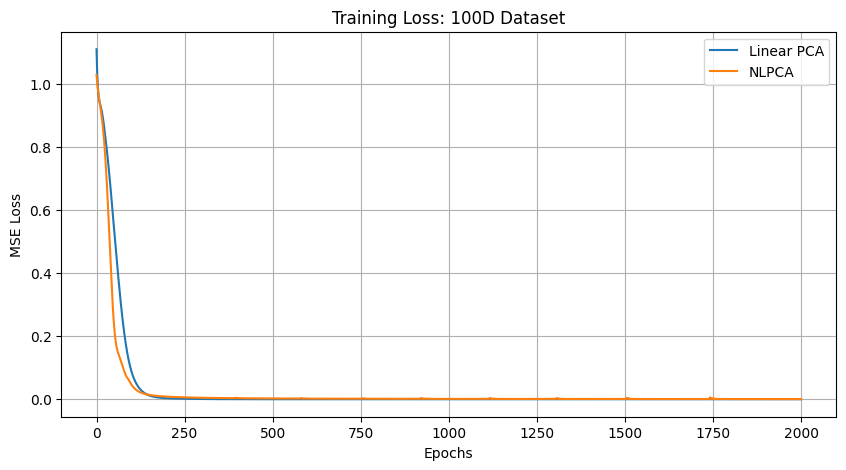

Final Linear PCA Loss: 0.000022
Final NLPCA Loss: 0.000476


In [8]:
# Parameters
input_dim_100 = dataset_100dim.get_input_dim()
bottleneck_dim_100 = 10
mapping_dim_100 = 50 # Change for tests
epochs = 2000

print(f"Training Models on 100D Dataset (Input Dim: {input_dim_100}, Bottleneck: {bottleneck_dim_100})...")

print("Linear PCA training...")
linear_model_100d = LinearPCAAutoencoder(input_dim_100, bottleneck_dim_100)
loss_linear_100d = train_model(linear_model_100d, dataloader_100dim, epochs=epochs)

print("NLPCA training...")
nlpca_model_100d = NLPCAAutoencoder(input_dim_100, mapping_dim_100, bottleneck_dim_100)
loss_nlpca_100d = train_model(nlpca_model_100d, dataloader_100dim, epochs=epochs)

# loss plots

plt.figure(figsize=(10, 5))
plt.plot(loss_linear_100d, label='Linear PCA')
plt.plot(loss_nlpca_100d, label='NLPCA')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss: 100D Dataset')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Linear PCA Loss: {loss_linear_100d[-1]:.6f}")
print(f"Final NLPCA Loss: {loss_nlpca_100d[-1]:.6f}")

Visualizing Random Sample from 100D Dataset...


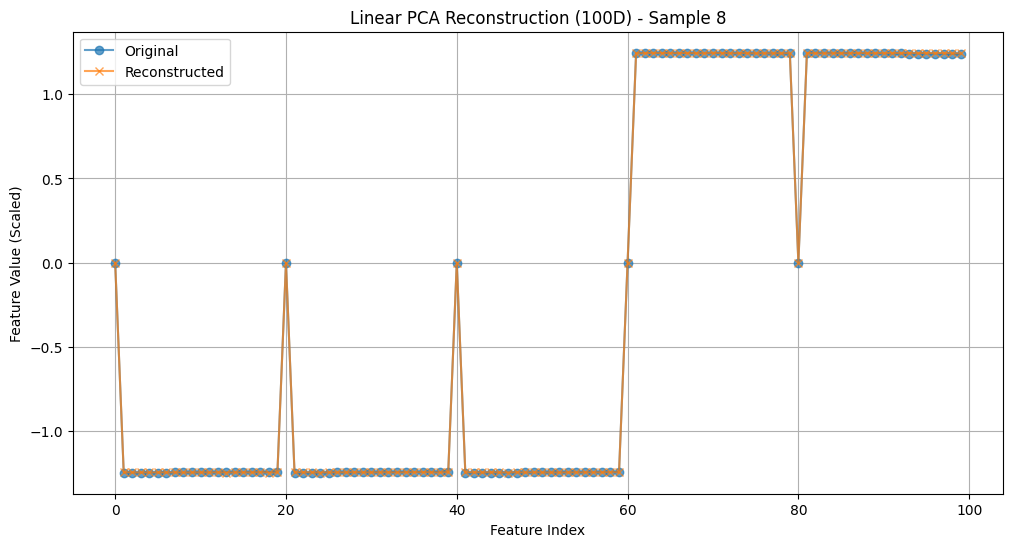

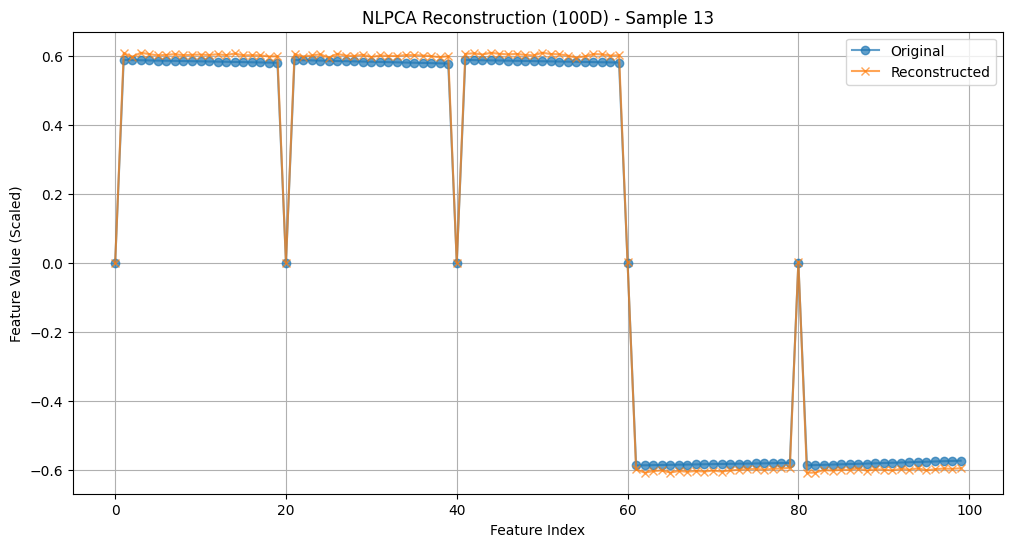

In [9]:
# asked llm for help but welp
def visualize_reconstruction_100d(model, dataset, title, num_samples=1):
    model.eval()
    with torch.no_grad():
        # Get all data
        data = dataset.data.to(device)
        reconstruction, _ = model(data)
        
        reconstruction = reconstruction.cpu().numpy()
        original = data.cpu().numpy()
        
        # Plot samples
        indices = np.random.choice(len(original), num_samples, replace=False)
        
        for i in indices:
            plt.figure(figsize=(12, 6))
            plt.plot(original[i], label='Original', marker='o', alpha=0.7)
            plt.plot(reconstruction[i], label='Reconstructed', marker='x', alpha=0.7)
            plt.xlabel('Feature Index')
            plt.ylabel('Feature Value (Scaled)')
            plt.title(f"{title} - Sample {i}")
            plt.legend()
            plt.grid(True)
            plt.show()

print("Visualizing Random Sample from 100D Dataset...")
visualize_reconstruction_100d(linear_model_100d, dataset_100dim, "Linear PCA Reconstruction (100D)")
visualize_reconstruction_100d(nlpca_model_100d, dataset_100dim, "NLPCA Reconstruction (100D)")